In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2019-07-09 12:48:57--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  12.5MB/s    in 23s     

2019-07-09 12:49:21 (11.3 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [0]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [4]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

--2019-07-09 12:49:33--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.86M  11.3MB/s    in 9.3s    

2019-07-09 12:49:43 (9.15 MB/s) - ‘GTSRB_Final_Test_Images.zip’ saved [88978620/88978620]



In [0]:
!unzip -qq GTSRB_Final_Test_Images.zip

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

cuda_available = torch.cuda.is_available()

In [32]:
Image.open('GTSRB/Final_Training/Images/00000/00000_00000.ppm')

In [33]:
Image.open('GTSRB/Final_Training/Images/00042/00000_00000.ppm')

In [0]:
dataset = 'GTSRB/Final_Training/Images'
test_dataset = 'GTSRB/Final_Test'

In [0]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((48, 48)),
    transforms.CenterCrop((32, 32)),
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root=dataset, transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_dataset, transform=transform)

valid_size = 0.2
num_train = len(train_data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=32)
validloader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

In [12]:
i, l = next(iter(trainloader))
i.shape

torch.Size([32, 3, 32, 32])

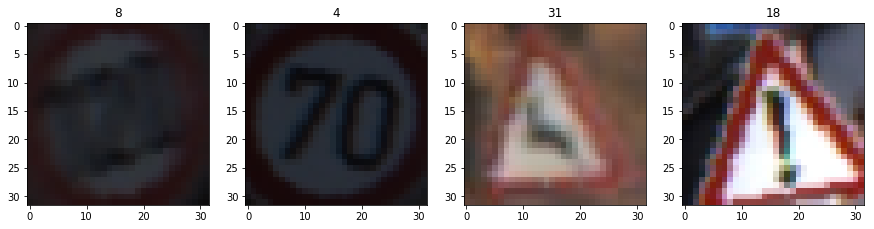

In [13]:
def show_images():
    images, label = next(iter(trainloader))
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 18))
    for i in range(4):
        img = np.array(images[i]).transpose(1,2,0)
        lab = np.array(label[i])
    
        
        ax[i].imshow(img)
        ax[i].set_title(lab)
        
show_images()

In [14]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 43)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
model = Network()

if cuda_available:
    model = model.cuda()
    
print(model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [0]:
def validation(model, validloader, criterion):
    
    test_loss = 0
    accuracy = 0
    
    for images, labels in validloader:
        
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
            
        logits = model(images)
        output = F.softmax(logits, dim=1)
        
        loss = criterion(logits, labels)
        test_loss += loss.item()
        
        _, indices = output.topk(1, dim=1)
        equals = labels == indices.view_as(labels)
        
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    return test_loss, accuracy

In [0]:
def train(model, trainloader, criterion, optimizer, epochs=5, print_every=50):
    
    min_test_loss = np.Inf
    
    for e in range(epochs):
        model.train()
        
        train_loss = 0
        
        for img, lab in trainloader:
            
            if cuda_available:
                img, lab = img.cuda(), lab.cuda()
                
            output = model(img)
            loss = criterion(output, lab)
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            test_loss, accuracy = validation(model, validloader, criterion)
        print('Epoch: {}/{} -- Train Loss: {:.3f} -- Valid Loss: {:.3f} -- Valid Accuracy: {:.3f}'.format(
                            e, epochs, train_loss/len(trainloader),
                            test_loss/len(validloader), accuracy/len(validloader)
                            ))
        
        if min_test_loss > test_loss:
            torch.save(model.state_dict(), 'drive/My Drive/Colab Notebooks/Traffic Sign Detector/checkpoint.pth')
            min_test_loss = test_loss
        
train(model, trainloader, criterion, optimizer, 20)

Epoch: 0/20 -- Train Loss: 0.611 -- Valid Loss: 0.102 -- Valid Accuracy: 0.975
Epoch: 1/20 -- Train Loss: 0.101 -- Valid Loss: 0.064 -- Valid Accuracy: 0.986
Epoch: 2/20 -- Train Loss: 0.066 -- Valid Loss: 0.043 -- Valid Accuracy: 0.989
Epoch: 3/20 -- Train Loss: 0.051 -- Valid Loss: 0.040 -- Valid Accuracy: 0.991
Epoch: 4/20 -- Train Loss: 0.041 -- Valid Loss: 0.045 -- Valid Accuracy: 0.989
Epoch: 5/20 -- Train Loss: 0.034 -- Valid Loss: 0.038 -- Valid Accuracy: 0.990
Epoch: 6/20 -- Train Loss: 0.030 -- Valid Loss: 0.034 -- Valid Accuracy: 0.992
Epoch: 7/20 -- Train Loss: 0.028 -- Valid Loss: 0.031 -- Valid Accuracy: 0.993
Epoch: 8/20 -- Train Loss: 0.024 -- Valid Loss: 0.069 -- Valid Accuracy: 0.981
Epoch: 9/20 -- Train Loss: 0.021 -- Valid Loss: 0.065 -- Valid Accuracy: 0.982
Epoch: 10/20 -- Train Loss: 0.020 -- Valid Loss: 0.026 -- Valid Accuracy: 0.995
Epoch: 11/20 -- Train Loss: 0.017 -- Valid Loss: 0.032 -- Valid Accuracy: 0.994
Epoch: 12/20 -- Train Loss: 0.021 -- Valid Loss: 0

In [16]:
#load the model
model.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/Traffic Sign Detector/checkpoint.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

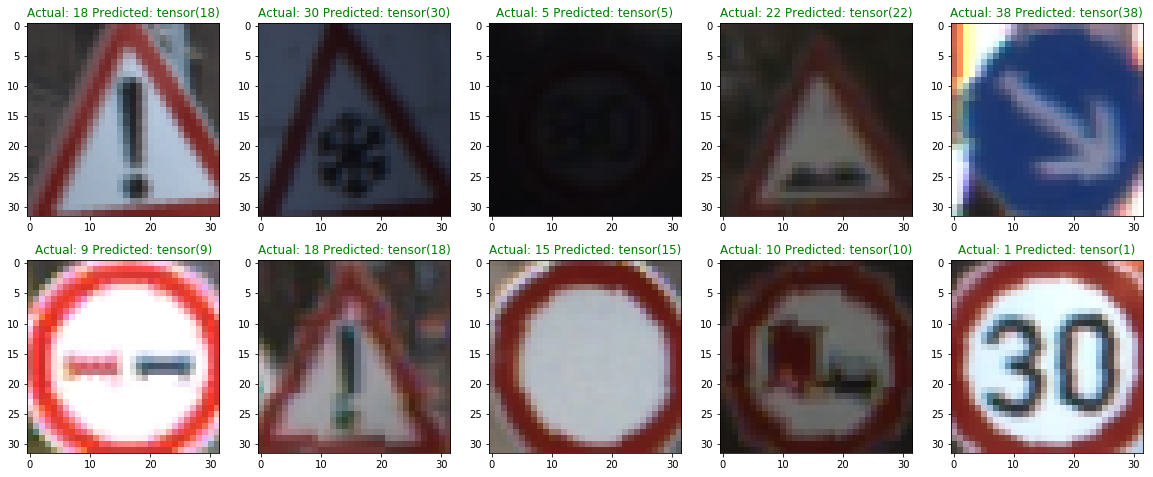

In [23]:
#visualizing on validation dataset

def show_images():
    images, label = next(iter(validloader))
    
    if cuda_available:
        images = images.cuda()
    logits = model(images)
    _, indices = output = logits.topk(1, dim=1)
    indices = indices.squeeze().cpu()
    
    images = images.cpu()
    
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(10):
        img = np.array(images[i]).transpose(1,2,0)
        lab = np.array(label[i])
    
        
        ax[i//5, i%5].imshow(img)
        if(lab==indices[i].item()):
            ax[i//5, i%5].set_title('Actual: '+str(lab)+' Predicted: '+str(indices[i]), color='green')
        else:
            ax[i//5, i%5].set_title('Acutal: '+str(lab)+' Predicted: '+str(indices[i]), color='red')
        
show_images()

In [22]:
def test(model, testloader):
    model.eval()
    
    test_pred = torch.LongTensor()
    
    for images, labels in testloader:
        
        if cuda_available:
            images = images.cuda()
            
        output = model(images)
        
        _, indices = output.topk(1, dim=1)
        indices = indices.squeeze().cpu()
        test_pred = torch.cat((test_pred, indices), dim=0)
        
        
    return test_pred

test_pred = test(model, testloader)
print(test_pred.shape)

torch.Size([12630])
